In [532]:
# Load data

import os
import glob
import h5py
import json
import numpy as np
import datetime
from scipy.optimize import curve_fit
from tqdm import tqdm
import matplotlib
# matplotlib.use('TkAgg')  # Set the interactive backend
import matplotlib.pyplot as plt


In [533]:
file_path = r"/Volumes/MBQD_data/AION/Data/2024/12/12/nb_BB2amp0p5_nbam0p5to0p25_B30to30_tofIII"

# Get a list of all HDF5 files in the directory
h5_files = glob.glob(os.path.join(file_path, '*.h5'))

h5_files

['/Volumes/MBQD_data/AION/Data/2024/12/12/nb_BB2amp0p5_nbam0p5to0p25_B30to30_tofIII/data_21_26_20_12_12_2024.h5',
 '/Volumes/MBQD_data/AION/Data/2024/12/12/nb_BB2amp0p5_nbam0p5to0p25_B30to30_tofIII/data_35_26_20_12_12_2024.h5',
 '/Volumes/MBQD_data/AION/Data/2024/12/12/nb_BB2amp0p5_nbam0p5to0p25_B30to30_tofIII/data_49_26_20_12_12_2024.h5',
 '/Volumes/MBQD_data/AION/Data/2024/12/12/nb_BB2amp0p5_nbam0p5to0p25_B30to30_tofIII/data_02_27_20_12_12_2024.h5',
 '/Volumes/MBQD_data/AION/Data/2024/12/12/nb_BB2amp0p5_nbam0p5to0p25_B30to30_tofIII/data_16_27_20_12_12_2024.h5',
 '/Volumes/MBQD_data/AION/Data/2024/12/12/nb_BB2amp0p5_nbam0p5to0p25_B30to30_tofIII/data_29_27_20_12_12_2024.h5',
 '/Volumes/MBQD_data/AION/Data/2024/12/12/nb_BB2amp0p5_nbam0p5to0p25_B30to30_tofIII/data_43_27_20_12_12_2024.h5',
 '/Volumes/MBQD_data/AION/Data/2024/12/12/nb_BB2amp0p5_nbam0p5to0p25_B30to30_tofIII/data_56_27_20_12_12_2024.h5',
 '/Volumes/MBQD_data/AION/Data/2024/12/12/nb_BB2amp0p5_nbam0p5to0p25_B30to30_tofIII/data

In [534]:
print(len(h5_files))

11


In [535]:
horizontal_camera_MOT_image_list = []
vertical_camera_MOT_image_list = []
time_of_flight_list = []

for file_path in h5_files:
    with h5py.File(file_path, 'r') as h5file:
        time_of_flight = json.loads(h5file['parameters'][()])["sequence_parameters"]["time_of_flight"]
        horizontal_camera_MOT_image = h5file['horizontal camera red mot'][:]
        vertical_camera_MOT_image = h5file['vertical camera red mot'][:]
    if np.sum(horizontal_camera_MOT_image) > 1e5 or np.sum(vertical_camera_MOT_image) > 1e5:
        horizontal_camera_MOT_image_list.append(horizontal_camera_MOT_image)
        vertical_camera_MOT_image_list.append(vertical_camera_MOT_image)
        time_of_flight_list.append(time_of_flight)

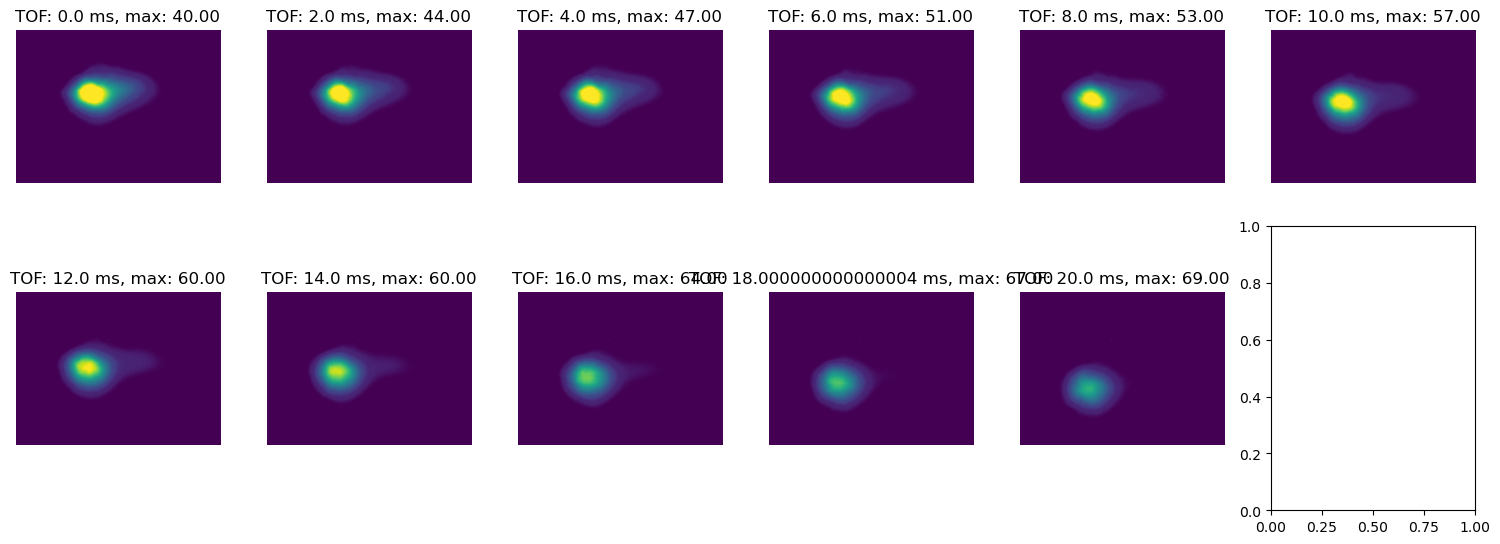

In [536]:

fig, axes = plt.subplots(2, 6, figsize=(15, 6))

for i, ax in enumerate(axes.flatten()):
    if i < len(horizontal_camera_MOT_image_list):
        ax.imshow(horizontal_camera_MOT_image_list[i],vmin=0,vmax=10,origin='lower')
        ax.set_title(f'TOF: {time_of_flight_list[i]*1000} ms, max: {np.max(horizontal_camera_MOT_image_list[i]):.2f}')
        ax.axis('off')

plt.tight_layout()
plt.show()

In [537]:
cleaned_horizontal_camera_MOT_image_list = []

for i in range(len(horizontal_camera_MOT_image_list)):
    raw_image = horizontal_camera_MOT_image_list[i]
    print("Raw image max value:", np.max(raw_image))
    # Automatically determine a high percentile threshold
    threshold_value = 99.99  # or 99.5 depending on how aggressive,  to get rid of stray high value pixels
    threshold = np.percentile(raw_image, threshold_value)
    print("Threshold value:", threshold)
    # Clip values above that threshold
    clean_image = np.clip(raw_image, a_min=None, a_max=threshold)
    print("Cleaned image new max value:", np.max(clean_image))

    cleaned_horizontal_camera_MOT_image_list.append(clean_image)

Raw image max value: 40
Threshold value: 17.0
Cleaned image new max value: 17.0
Raw image max value: 44
Threshold value: 14.0
Cleaned image new max value: 14.0
Raw image max value: 47
Threshold value: 14.0
Cleaned image new max value: 14.0
Raw image max value: 51
Threshold value: 14.0
Cleaned image new max value: 14.0
Raw image max value: 53
Threshold value: 13.0
Cleaned image new max value: 13.0
Raw image max value: 57
Threshold value: 12.0
Cleaned image new max value: 12.0
Raw image max value: 60
Threshold value: 11.0
Cleaned image new max value: 11.0
Raw image max value: 60
Threshold value: 10.0
Cleaned image new max value: 10.0
Raw image max value: 64
Threshold value: 9.0
Cleaned image new max value: 9.0
Raw image max value: 67
Threshold value: 8.0
Cleaned image new max value: 8.0
Raw image max value: 69
Threshold value: 7.0
Cleaned image new max value: 7.0


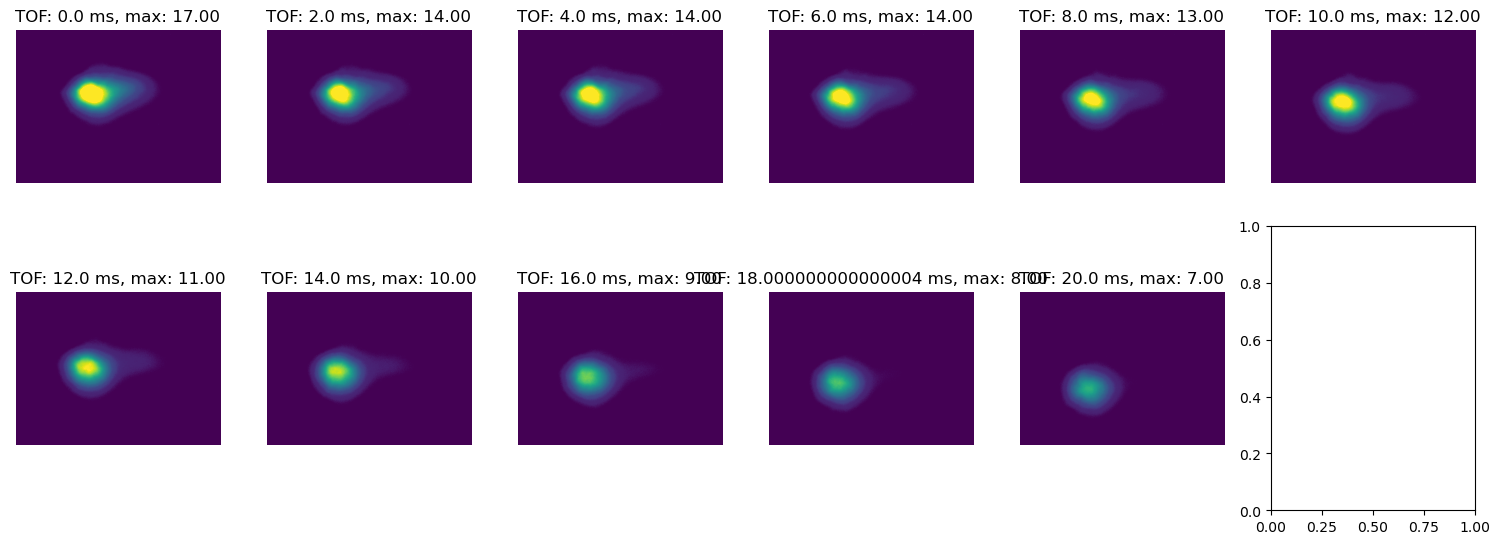

In [538]:

fig, axes = plt.subplots(2, 6, figsize=(15, 6))

for i, ax in enumerate(axes.flatten()):
    if i < len(cleaned_horizontal_camera_MOT_image_list):
        ax.imshow(cleaned_horizontal_camera_MOT_image_list[i],vmin=0,vmax=10,origin='lower')
        ax.set_title(f'TOF: {time_of_flight_list[i]*1000} ms, max: {np.max(cleaned_horizontal_camera_MOT_image_list[i]):.2f}')
        ax.axis('off')

plt.tight_layout()
plt.show()

In [539]:
# test
image = cleaned_horizontal_camera_MOT_image_list[5]


In [540]:
from scipy.optimize import curve_fit

# Define the 2D Gaussian function
def gaussian2D(xy_coordinates, amplitude, x_0, y_0, sigma_x, sigma_y, theta, offset):
    x, y = xy_coordinates # xy is a tuple of x and y coordinates
    a = (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
    b = -(np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
    c = (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
    gaussian_output = offset + amplitude * np.exp(-(a * (x - x_0)**2 + 2 * b * (x - x_0) * (y - y_0) + c * (y - y_0)**2))
    return gaussian_output.ravel() # Flatten the output to 1D array for curve_fit

# Create the 2D grid for coordinates
x = np.arange(image.shape[1]) # This is how many pixels in the x direction
y = np.arange(image.shape[0]) # This is how many pixels in the y direction
x, y = np.meshgrid(x, y) # # Generate 2D mesh grid of coordinates
xy_coordinates = (x, y) # To fit a function of two variables like f(x, y), need to wrap x and y into a single argument (like a tuple)

# Initial guess for the parameters
guess_amplitude = np.max(image)                         # Peak value
guess_x_0 = np.argmax(np.max(image, axis=0))     # Find position of max in column (x)
guess_y_0 = np.argmax(np.max(image, axis=1))     # Find position of max in row (y)
guess_sigma_x = 200                
guess_sigma_y = 200
guess_theta = 0.0
guess_offset = np.min(image)                     # Background
p0 = (guess_amplitude, guess_x_0, guess_y_0, guess_sigma_x, guess_sigma_y, guess_theta, guess_offset)

# Fit the data
popt, pcov = curve_fit(gaussian2D, xy_coordinates, image.ravel(), p0=p0) # Need to flatten the image(target/output to fit to) to 1D array for curve_fit using ravel()
# popt contains the optimal values for the parameters
# pcov contains the covariance of the parameters

In [541]:
print("Fitted Parameters:")
print(f"Amplitude: {popt[0]}")
print(f"x_0: {popt[1]}")
print(f"y_0: {popt[2]}")
print(f"Sigma_x: {popt[3]}")
print(f"Sigma_y: {popt[4]}")
print(f"Theta: {popt[5]}")
print(f"Offset: {popt[6]}")

Fitted Parameters:
Amplitude: 11.418026974681831
x_0: 728.8998441421386
y_0: 798.3400990625731
Sigma_x: 102.32912031118656
Sigma_y: 133.25810851010618
Theta: 1.717918389040326
Offset: 0.027538159596437725


In [542]:
sigma_x_uncertainty = np.sqrt(np.diag(pcov)[3]) # Extract the uncertainty of sigma_x from the covariance matrix
sigma_y_uncertainty = np.sqrt(np.diag(pcov)[4]) # Extract the uncertainty of sigma_y from the covariance matrix
print(f"Sigma_x is {round(popt[3],3)} ± {round(sigma_x_uncertainty,3)}")
print(f"Sigma_y is {round(popt[4],3)} ± {round(sigma_y_uncertainty,3)}")


Sigma_x is 102.329 ± 0.016
Sigma_y is 133.258 ± 0.021


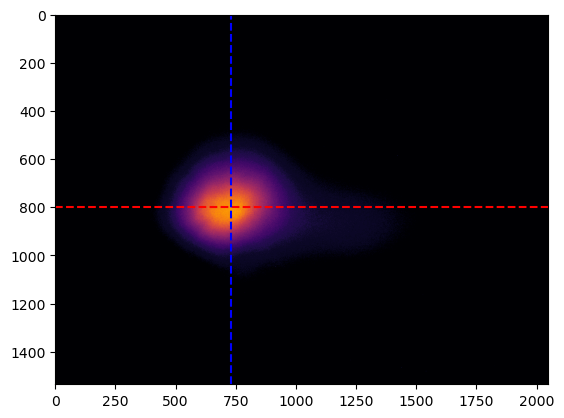

In [543]:
plt.imshow(image, cmap='inferno', vmin=0, vmax=15)
plt.axhline(popt[2], color='red', linestyle='--', label='y_0')
plt.axvline(popt[1], color='blue', linestyle='--', label='x_0')

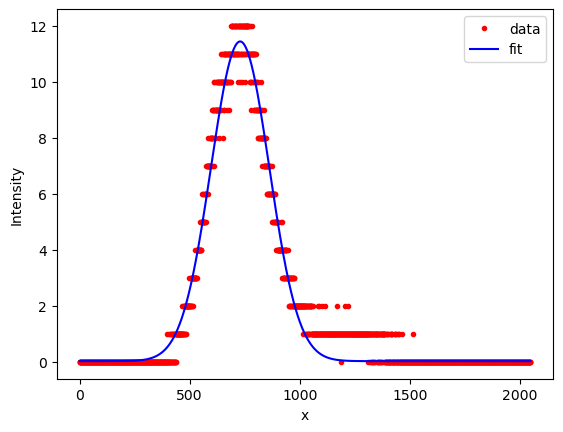

In [544]:
plt.plot(np.arange(image.shape[1]), image[int(popt[2]),:], 'r.', label='data')
plt.plot(np.arange(image.shape[1]), gaussian2D((np.arange(image.shape[1]), int(popt[2])), *popt), 'b-', label='fit')
plt.xlabel('x')
plt.ylabel('Intensity')
plt.legend()

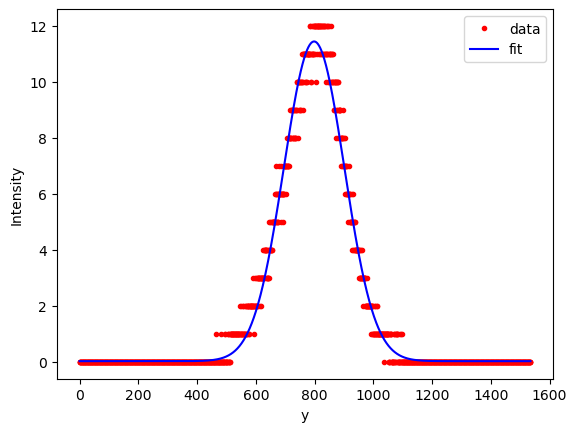

In [545]:
plt.plot(np.arange(image.shape[0]), image[:, int(popt[1])], 'r.', label='data')
plt.plot(np.arange(image.shape[0]), gaussian2D((int(popt[1]), np.arange(image.shape[0])), *popt), 'b-', label='fit')
plt.xlabel('y')
plt.ylabel('Intensity')
plt.legend()

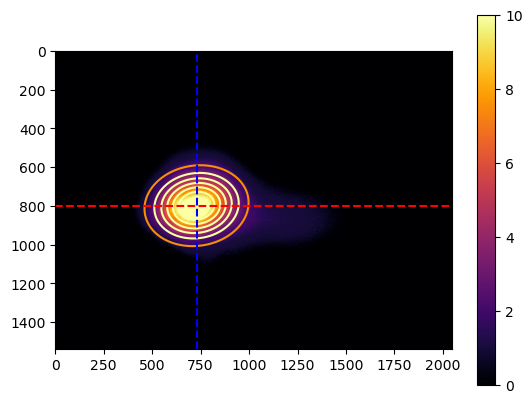

In [546]:
fitted_gaussian = gaussian2D(xy_coordinates, *popt).reshape(image.shape) #reshape is basically reverse of ravel
plt.contour(fitted_gaussian, cmap='inferno', vmin=0, vmax=2)
plt.imshow(image, cmap='inferno', vmin=0, vmax=10) # Overlay the fitted Gaussian on the original image
plt.colorbar()
plt.axhline(popt[2], color='red', linestyle='--', label='y_0')
plt.axvline(popt[1], color='blue', linestyle='--', label='x_0')

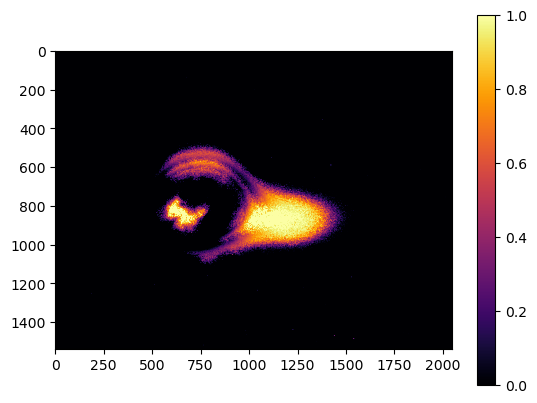

In [547]:
residue = image - fitted_gaussian
plt.imshow(residue, cmap='inferno', vmin=0, vmax=1)
plt.colorbar()

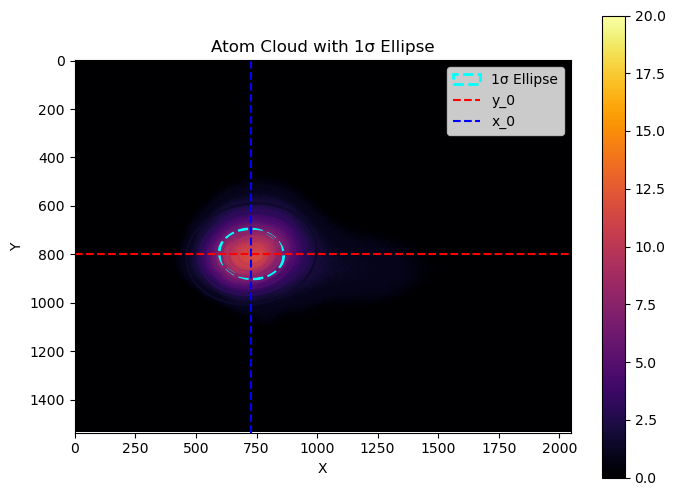

In [548]:
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(image, cmap='inferno', vmin=0, vmax=20)
ax.contour(fitted_gaussian, cmap='inferno', vmin=0, vmax=20)

# Add ellipses for sigma_x and sigma_y
ellipse = Ellipse((popt[1], popt[2]), 
                  width=2*popt[3], 
                  height=2*popt[4], 
                  angle=np.degrees(popt[5]), 
                  edgecolor='cyan', 
                  facecolor='none', 
                  linestyle='--', 
                  linewidth=2, label='1σ Ellipse')
ax.add_patch(ellipse)

# Add crosshairs for the center
ax.axhline(popt[2], color='red', linestyle='--', label='y_0')
ax.axvline(popt[1], color='blue', linestyle='--', label='x_0')

# Add legend and labels
ax.legend()
ax.set_title("Atom Cloud with 1σ Ellipse")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.colorbar(ax.imshow(image, cmap='inferno', vmin=0, vmax=20), ax=ax)
plt.show()

# 250503 Nice four figure column plot

In [549]:
# copy paste this code to the beginning of your script to set the plotting style for a two column figure

from matplotlib import pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    # "figure.constrained_layout.use": True
})

plt.rcParams["figure.autolayout"] = False # set to True if you want to use constrained_layout

plt.rcParams["savefig.bbox"] = None
plt.rcParams["figure.figsize"] = (5.9,1.5)
plt.rcParams["figure.titlesize"] = 10 # this is only for plt.suptitle, i set it to be the same as the rest

plt.rcParams["axes.titlesize"] = 10 # control title size
plt.rcParams["axes.labelsize"] = 10 # control x and y axis labels
plt.rcParams["axes.labelpad"] = 4.0 # distance between axis label and axis numbers
plt.rcParams["xtick.labelsize"] = 10 # independent control of xlabel fontsize
plt.rcParams["ytick.labelsize"] = 10 # independent control of ylabel fontsize

plt.rcParams["legend.fontsize"] = 7.5 # control legend size, I set it to be slightly smaller than title/axes label
# plt.rcParams["legend.facecolor"] = (0.9, 0.9, 0.9) # legend background color
# plt.rcParams["legend.edgecolor"] = (0, 0, 0) # legend border line color
# plt.rcParams["legend.frameon"] = True # whether or not to draw a border around legend
# plt.rcParams["legend.framealpha"] = 0.1 # legend background transparency
plt.rcParams["legend.loc"] = "upper left" # default legend location
plt.rcParams["legend.handletextpad"] = 0.8  # Horizontal space between legend point and text (default 0.8)
plt.rcParams["legend.labelspacing"] = 0.6  # Vertical space between legend entries (default 0.5)
# plt.rcParams["legend.columnspacing"] = 2.0  # Space between columns in multi-column legends
# plt.rcParams["legend.borderpad"] = 1.0  # Space between legend content and the box
# plt.rcParams["legend.handlelength"] = 2.0  # Length of legend marker lines

plt.rcParams["lines.linewidth"] = 1
plt.rcParams["lines.markersize"] = 6 #data point size

# CHOOSE NICE COLOR FOR DARK MARKER EDGEWIDTH FROM "dodgerblue","mediumseagreen","crimson","mediumpurple","slateblue","darkorange","peru","goldenrod"
# plt.rcParams["lines.linewidth"] = 1
# plt.rcParams["lines.markersize"] = 6 #data point size
# plt.rcParams["lines.markeredgewidth"] = 1.5 # width of the edge of the marker
# plt.rcParams["lines.markeredgecolor"] = "black" # color of the edge of the marker
# plt.rcParams["lines.markerfacecolor"] = "dodgerblue" # color of the inside of the marker
# plt.rcParams["lines.marker"] = "o" # marker type, see https://matplotlib.org/stable/api/markers_api.html for all options
# plt.rcParams["lines.color"] = "black" # color of the line
# # CHOOSE NICE COLOR FOR DARK MARKER EDGEWIDTH FROM "dodgerblue","mediumseagreen","crimson","mediumpurple","slateblue","darkorange","peru","goldenrod"

plt.rcParams["grid.linestyle"] = "--"
plt.rcParams['axes.grid'] = True
# plt.rcParams["grid.linewidth"] = 0.7

# plt.rcParams["xtick.major.pad"] = 4.0 # distance between xticks dashes and xaxis numbers
# plt.rcParams["xtick.major.size"] = 3.0
# plt.rcParams["xtick.major.width"] = 0.7
# plt.rcParams["ytick.major.pad"] = 4.0 # distance between yticks dashes and yaxis numbers
# plt.rcParams["ytick.major.size"] = 3.0
# plt.rcParams["ytick.major.width"] = 0.7





# plot two figures side by side
# fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, constrained_layout=True)
# plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2) # remove unnecessary white space how i like it, this is manual very of use constrained_layout

# That warning is because matplotlib’s default layout engine has changed in recent
# versions to use constrained_layout, which is incompatible with subplots_adjust and tight_layout. 
# If you try to use plt.subplots_adjust when constrained_layout=True, matplotlib will raise that warning and ignore the call.
# If you're manually adjusting spacing, disable constrained_layout when you create the figure:

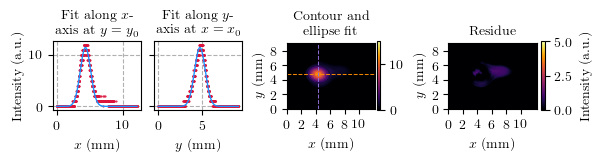

In [561]:
# okay im done messing around, time to plot all of them side by side in a four column panel

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,constrained_layout=True)

# Plot the first plot which is the fit along the x-axis slice

pixel_size_mm = (1/0.58)*3.45/1000  # how many mm per pixel
ax1.plot(np.arange(image.shape[1])*pixel_size_mm, image[int(popt[2]),:], '.', markersize=1,color='crimson', label='Data')
ax1.plot(np.arange(image.shape[1])*pixel_size_mm, gaussian2D((np.arange(image.shape[1]), int(popt[2])), *popt), '-', color='dodgerblue', label='Fit')
ax1.set_xlabel(r'$x$ (mm)')
ax1.set_ylabel('Intensity (a.u.)')
ax1.set_title(r'Fit along $x$-'+ '\n' +r'axis at $y=y_0$')
# ax1.legend(loc='lower right')

# Plot the second plot which is the fit along the y-axis slice

ax2.plot(np.arange(image.shape[0])*pixel_size_mm, image[:, int(popt[1])], '.', markersize=1,color='crimson', label='Data')
ax2.plot(np.arange(image.shape[0])*pixel_size_mm, gaussian2D((int(popt[1]), np.arange(image.shape[0])), *popt), '-', color='dodgerblue', label='Fit')
ax2.set_xlabel(r'$y$ (mm)')
ax2.set_title(r'Fit along $y$-'+ '\n' +r'axis at $x=x_0$')
# ax2.legend(loc='lower left')

# Plot the third plot which is the image and contour line fit

fitted_gaussian = gaussian2D(xy_coordinates, *popt).reshape(image.shape) #reshape is basically reverse of ravel
im3 = ax3.imshow(image, cmap='inferno', vmin=0, vmax=15,origin='lower') # Overlay the fitted Gaussian on the original image
ax3.contour(fitted_gaussian, cmap='inferno', vmin=0, vmax=15)
ax3.grid(False)
ax3.set_title('Contour and \n ellipse fit')
# Add ellipses for sigma_x and sigma_y
ellipse = Ellipse((popt[1], popt[2]), 
                  width=2*popt[3], 
                  height=2*popt[4], 
                  angle=np.degrees(popt[5]), 
                  edgecolor='cyan', 
                  facecolor='none', 
                  linestyle='--', 
                  linewidth=0.5, label=r'1$\sigma$')
ax3.add_patch(ellipse)
# Add crosshairs for the center
ax3.axhline(popt[2], color='darkorange', linestyle='--', alpha=0.95, lw=0.75, label=r'$y_0$')
ax3.axvline(popt[1], color='mediumpurple', linestyle='--', alpha=0.95, lw=0.75,label=r'$x_0$')
# ax3.legend()
# Define nice physical tick positions
x_physical_ticks = np.arange(0, 11, 2)  # mm
y_physical_ticks = np.arange(0, 9, 2)  # mm
# Convert to pixel units
x_pixel_ticks = [x / pixel_size_mm for x in x_physical_ticks]
y_pixel_ticks = [y / pixel_size_mm for y in y_physical_ticks]
# Set the ticks on the axes
ax3.set_xticks(x_pixel_ticks)
ax3.set_xticklabels([f"{x:.0f}" for x in x_physical_ticks])
ax3.set_yticks(y_pixel_ticks)
ax3.set_yticklabels([f"{y:.0f}" for y in y_physical_ticks])
ax3.set_xlabel(r'$x$ (mm)')
ax3.set_ylabel(r'$y$ (mm)')
# Add colorbar
cbar = plt.colorbar(im3, ax=ax3,shrink=1, pad=0.025)
# cbar.set_label('Intensity (a.u.)')

# Plot the fourth plot which is the residue
residue = image - fitted_gaussian
im4 = ax4.imshow(residue, cmap='inferno', vmin=0, vmax=5,origin='lower')
ax4.grid(False)
ax4.set_title('Residue')
# Define nice physical tick positions
x_physical_ticks = np.arange(0, 11, 2)  # mm
y_physical_ticks = np.arange(0, 9, 2)  # mm
# Convert to pixel units
x_pixel_ticks = [x / pixel_size_mm for x in x_physical_ticks]
y_pixel_ticks = [y / pixel_size_mm for y in y_physical_ticks]
# Set the ticks on the axes
ax4.set_xticks(x_pixel_ticks)
ax4.set_xticklabels([f"{x:.0f}" for x in x_physical_ticks])
ax4.set_yticks(y_pixel_ticks)
ax4.set_yticklabels([f"{y:.0f}" for y in y_physical_ticks])
ax4.set_xlabel(r'$x$ (mm)')
ax4.set_ylabel(r'$y$ (mm)')
# Add colorbar
cbar = plt.colorbar(im4, ax=ax4,shrink=1, pad=0.055)
cbar.set_label('Intensity (a.u.)')

# Share y-axis between ax1 and ax2
ax2.sharey(ax1)

# Share y-axis between ax3 and ax4
ax4.sharey(ax3)

ax2.tick_params(labelleft=False)
# ax4.tick_params(labelleft=False)

plt.savefig('250503 NbRedMOTGaussianFitFourColumnPlot.pdf',dpi=300)

# 250503 Diagnostic plot: plot out four column figure for all dataset to check fitting

In [551]:
# for i, (image, tof) in enumerate(zip(cleaned_horizontal_camera_MOT_image_list, time_of_flight_list)):
#     # Create the 2D grid for coordinates
#     x = np.arange(image.shape[1])  # This is how many pixels in the x direction
#     y = np.arange(image.shape[0])  # This is how many pixels in the y direction
#     x, y = np.meshgrid(x, y)  # Generate 2D mesh grid of coordinates
#     xy_coordinates = (x, y)  # Wrap x and y into a single argument (like a tuple)

#     # Initial guess for the parameters
#     guess_amplitude = np.max(image)  # Peak value
#     guess_x_0 = np.argmax(np.max(image, axis=0))  # Find position of max in column (x)
#     guess_y_0 = np.argmax(np.max(image, axis=1))  # Find position of max in row (y)
#     guess_sigma_x = 200
#     guess_sigma_y = 200
#     guess_theta = 0.0
#     guess_offset = np.min(image)  # Background
#     p0 = (guess_amplitude, guess_x_0, guess_y_0, guess_sigma_x, guess_sigma_y, guess_theta, guess_offset)

#     # Fit the data
#     try:
#         popt, pcov = curve_fit(gaussian2D, xy_coordinates, image.ravel(), p0=p0)

#         # Extract fitted Gaussian
#         fitted_gaussian = gaussian2D(xy_coordinates, *popt).reshape(image.shape)

#         # Plot the results
#         fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, constrained_layout=True, figsize=(15, 3))

#         # Plot the first plot: fit along the x-axis slice
#         pixel_size_mm = (1 / 0.58) * 3.45 / 1000  # mm per pixel
#         ax1.plot(np.arange(image.shape[1]) * pixel_size_mm, image[int(popt[2]), :], '.', markersize=1, color='crimson', label='Data')
#         ax1.plot(np.arange(image.shape[1]) * pixel_size_mm, gaussian2D((np.arange(image.shape[1]), int(popt[2])), *popt), '-', color='dodgerblue', label='Fit')
#         ax1.set_xlabel(r'$x$ (mm)')
#         ax1.set_ylabel('Intensity (a.u.)')
#         ax1.set_title(r'Fit along $x$-' + '\n' + r'axis at $y=y_0$')

#         # Plot the second plot: fit along the y-axis slice
#         ax2.plot(np.arange(image.shape[0]) * pixel_size_mm, image[:, int(popt[1])], '.', markersize=1, color='crimson', label='Data')
#         ax2.plot(np.arange(image.shape[0]) * pixel_size_mm, gaussian2D((int(popt[1]), np.arange(image.shape[0])), *popt), '-', color='dodgerblue', label='Fit')
#         ax2.set_xlabel(r'$y$ (mm)')
#         ax2.set_title(r'Fit along $y$-' + '\n' + r'axis at $x=x_0$')

#         # Plot the third plot: image and contour line fit
#         im3 = ax3.imshow(image, cmap='inferno', vmin=0, vmax=15, origin='lower')  # Overlay the fitted Gaussian on the original image
#         ax3.contour(fitted_gaussian, cmap='inferno', vmin=0, vmax=10)
#         ax3.grid(False)
#         ax3.set_title('Contour ellipse fit, \n sigma_x = %.2f mm' % (popt[3]*pixel_size_mm))
#         ellipse = Ellipse((popt[1], popt[2]), width=2 * popt[3], height=2 * popt[4], angle=np.degrees(popt[5]),
#                           edgecolor='cyan', facecolor='none', linestyle='--', linewidth=0.5, label=r'1$\sigma$')
#         ax3.add_patch(ellipse)
#         ax3.axhline(popt[2], color='darkorange', linestyle='--', alpha=0.95, lw=0.75, label=r'$y_0$')
#         ax3.axvline(popt[1], color='mediumpurple', linestyle='--', alpha=0.95, lw=0.75, label=r'$x_0$')
#         ax3.set_xlabel(r'$x$ (mm)')
#         ax3.set_ylabel(r'$y$ (mm)')
#         cbar = plt.colorbar(im3, ax=ax3, shrink=1, pad=0.025)

#         # Plot the fourth plot: residue
#         residue = image - fitted_gaussian
#         im4 = ax4.imshow(residue, cmap='inferno', vmin=0, vmax=5, origin='lower')
#         ax4.grid(False)
#         ax4.set_title(f'Residue, \n TOF: {tof * 1000:.1f} ms')
#         ax4.set_xlabel(r'$x$ (mm)')
#         ax4.set_ylabel(r'$y$ (mm)')
#         cbar = plt.colorbar(im4, ax=ax4, shrink=1, pad=0.055)
#         cbar.set_label('Intensity (a.u.)')

#         plt.show()

#     except Exception as e:
#         print(f"Skipping TOF {tof} due to fitting error: {e}")

# 250503 Extract radius AND uncertainty. Now we extract all of the sigma radius to perform time of flight fitting to extract temperature

In [552]:
def extract_sigma_tof_list_from_h5_files(file_path,clean_threshold=None):

    ### ---------------------- LOAD DATA ---------------------- ###

    # First we define a fiunction that takes all the h5 files as input then outputs three lists: time of flights, horizontal images, and vertical images
    # Get a list of all HDF5 files in the directory
    h5_files = glob.glob(os.path.join(file_path, '*.h5'))

    horizontal_camera_MOT_image_list = []
    vertical_camera_MOT_image_list = []
    time_of_flight_list = []

    for file_path in h5_files:
        with h5py.File(file_path, 'r') as h5file:
            time_of_flight = json.loads(h5file['parameters'][()])["sequence_parameters"]["time_of_flight"]
            horizontal_camera_MOT_image = h5file['horizontal camera red mot'][:]
            vertical_camera_MOT_image = h5file['vertical camera red mot'][:]
        if np.sum(horizontal_camera_MOT_image) > 1e5 or np.sum(vertical_camera_MOT_image) > 1e5:
            horizontal_camera_MOT_image_list.append(horizontal_camera_MOT_image)
            vertical_camera_MOT_image_list.append(vertical_camera_MOT_image)
            time_of_flight_list.append(time_of_flight)

    ### ---------------------- CLEANING IMAGES ---------------------- ###
    
    cleaned_horizontal_camera_MOT_image_list = []

    if clean_threshold is None:
        # Set default threshold using 99.9th percentile if no threshold is provided in function
        threshold_value = 99.99 # this removes the top 0.01% of pixels so we only see the true gaussian and not random bright pixels, adjust accordingly
    for i in range(len(horizontal_camera_MOT_image_list)):
        raw_image = horizontal_camera_MOT_image_list[i]
        # Automatically determine a high percentile threshold
        threshold = np.percentile(raw_image, threshold_value)
        # Clip values above that threshold
        clean_image = np.clip(raw_image, a_min=None, a_max=threshold)
        cleaned_horizontal_camera_MOT_image_list.append(clean_image)

    ### ---------------------- GAUSSIAN FITTING ---------------------- ###

    # Define the 2D Gaussian function for fitting
    def gaussian2D(xy_coordinates, amplitude, x_0, y_0, sigma_x, sigma_y, theta, offset):
        x, y = xy_coordinates # xy is a tuple of x and y coordinates
        a = (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
        b = -(np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
        c = (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
        gaussian_output = offset + amplitude * np.exp(-(a * (x - x_0)**2 + 2 * b * (x - x_0) * (y - y_0) + c * (y - y_0)**2))
        return gaussian_output.ravel() # Flatten the output to 1D array for curve_fit

    results_dict = {} # Store results in dictionary

    for i in tqdm(range(len(cleaned_horizontal_camera_MOT_image_list))):
        tof = time_of_flight_list[i]
        image = cleaned_horizontal_camera_MOT_image_list[i] #extract the images

        # Create the 2D grid for coordinates
        x = np.arange(image.shape[1]) # This is how many pixels in the x direction
        y = np.arange(image.shape[0]) # This is how many pixels in the y direction
        x, y = np.meshgrid(x, y) # # Generate 2D mesh grid of coordinates
        xy_coordinates = (x, y) # To fit a function of two variables like f(x, y), need to wrap x and y into a single argument (like a tuple)

        # Initial guess for the parameters
        guess_amplitude = np.max(image)                         # Peak value
        guess_x_0 = np.argmax(np.max(image, axis=0))     # Find position of max in column (x)
        guess_y_0 = np.argmax(np.max(image, axis=1))     # Find position of max in row (y)
        guess_sigma_x = 200                
        guess_sigma_y = 200
        guess_theta = 0.0
        guess_offset = np.min(image)                     # Background
        p0 = (guess_amplitude, guess_x_0, guess_y_0, guess_sigma_x, guess_sigma_y, guess_theta, guess_offset)

        try:
            # Attempt Fit the data
            popt, pcov = curve_fit(gaussian2D, xy_coordinates, image.ravel(), p0=p0) # Need to flatten the image(target/output to fit to) to 1D array for curve_fit using ravel()
            # popt contains the optimal values for the parameters
            # pcov contains the covariance of the parameters

            sigma_x = popt[3]
            sigma_y = popt[4]
            sigma_x_uncertainty = np.sqrt(np.diag(pcov)[3])
            sigma_y_uncertainty = np.sqrt(np.diag(pcov)[4])
        
            # Store in dictionary — use time of flight as the key
            results_dict[tof] = {
                'sigma_x': sigma_x,
                'sigma_x_uncertainty': sigma_x_uncertainty,
                'sigma_y': sigma_y,
                'sigma_y_uncertainty': sigma_y_uncertainty}
        except Exception as e:
            print(f"Skipping TOF {tof} due to fitting error: {e}")
            continue

    return results_dict

#### Run script above, then save data

In [564]:
import pickle

file_name_to_be_saved_as = '250503_NbRedMOT_TOF_Results_Data_241212_30Ato30A_tofIII.pkl'
file_path = r"/Volumes/MBQD_data/AION/Data/2024/12/12/nb_BB2amp0p5_nbam0p5to0p25_B30to30_tofIII"

# Run once and save data using pickle, so don't need to waste time running the function again
data = extract_sigma_tof_list_from_h5_files(file_path=file_path)
with open(file_name_to_be_saved_as, 'wb') as f:
    pickle.dump(data, f)

100%|██████████| 11/11 [01:17<00:00,  7.07s/it]


#### Load data if you don't want to re-run again

In [569]:
# Load the data from the pickle file and plot the results
import pickle

file_name_to_be_loaded = '250503_NbRedMOT_TOF_Results_Data_241212_30Ato30A_tofIII.pkl'

# --- Load later without recomputing ---
with open(file_name_to_be_loaded, 'rb') as f:
    data = pickle.load(f)

In [570]:
# Print the results of the dictionary

print(json.dumps(data, indent=4))

{
    "0.0": {
        "sigma_x": 146.1836467214963,
        "sigma_x_uncertainty": 0.02780403681123381,
        "sigma_y": 96.26158397507265,
        "sigma_y_uncertainty": 0.018309250605819435
    },
    "0.002": {
        "sigma_x": 97.46475805058557,
        "sigma_x_uncertainty": 0.018426425763905765,
        "sigma_y": 137.31164287170964,
        "sigma_y_uncertainty": 0.025959290334588936
    },
    "0.004": {
        "sigma_x": 98.84914738685528,
        "sigma_x_uncertainty": 0.018144977905425165,
        "sigma_y": 136.4033372351483,
        "sigma_y_uncertainty": 0.025038255672583463
    },
    "0.006": {
        "sigma_x": 98.54056667853342,
        "sigma_x_uncertainty": 0.017931031063572602,
        "sigma_y": 135.89508666869398,
        "sigma_y_uncertainty": 0.024728061359049026
    },
    "0.008": {
        "sigma_x": 99.81762482664871,
        "sigma_x_uncertainty": 0.016798583575383278,
        "sigma_y": 133.94994207435448,
        "sigma_y_uncertainty": 0.022542670

In [571]:
len(data)

11

#### Extract temperature

Temperature from sigma_x: 3.83 ± 0.24 uK
Temperature from sigma_y: -2.85 ± 0.37 uK


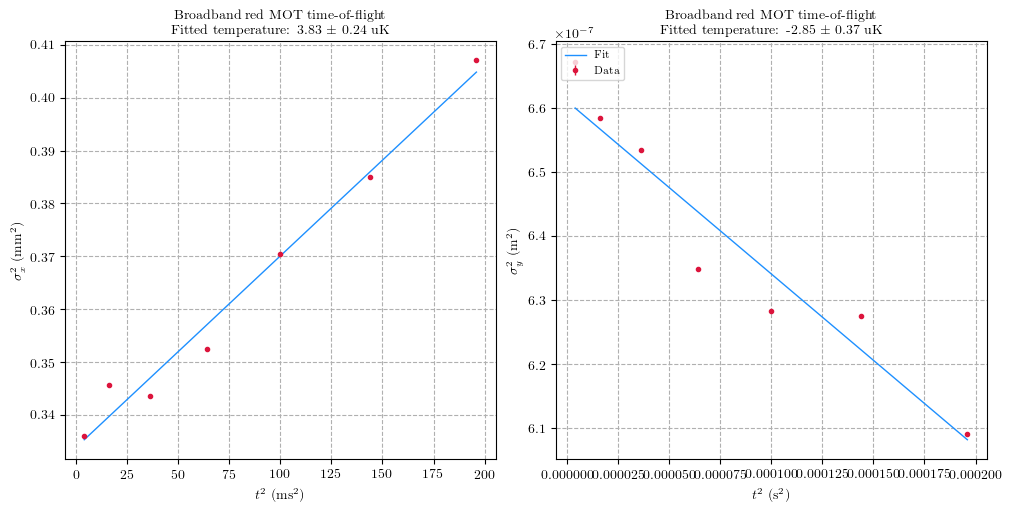

In [574]:
# ENSURE EVERYONE IS IN SI UNITS (i.e. meters and seconds)

pixel_size_m = (1/0.58)*3.45/1000000  # how many m per pixel

sigma_x_list = []
sigma_x_uncertainty_list = []
sigma_y_list = []
sigma_y_uncertainty_list = []
for tof in data.keys():
    sigma_x_list.append(data[tof]['sigma_x']*pixel_size_m) # convert to um
    sigma_x_uncertainty_list.append(data[tof]['sigma_x_uncertainty']*pixel_size_m)
    sigma_y_list.append(data[tof]['sigma_y']*pixel_size_m) # convert to um
    sigma_y_uncertainty_list.append(data[tof]['sigma_y_uncertainty']*pixel_size_m)
tof_list = list(data.keys())

# Now fit the sigma_x and sigma_y to a function of time of flight

# Constants
m = 88*1.66e-27 # mass of Sr88 in kg
kB = 1.38e-23 # Boltzmann constant in J/K

# equation for tof is sigma_t^2 = (kB*T/m)*t^2 + sigma_0^2
# equating this to y=mx+c, we have:
    # y = sigma_t^2
    # slope m = kB*T/m
    # x = t^2
    # c = sigma_0^2

sigma_x_squared_list = np.array(sigma_x_list)**2
sigma_y_squared_list = np.array(sigma_y_list)**2
tof_squared_list = np.array(tof_list)**2

# uncertainties
sigma_x_squared_uncertainty_list = 2 * np.array(sigma_x_list) * np.array(sigma_x_uncertainty_list)
sigma_y_squared_uncertainty_list = 2 * np.array(sigma_y_list) * np.array(sigma_y_uncertainty_list)

# Fit the data to the equation
def linear_func(x, m, c):
    return m * x + c #y = mx + c

### ----------------------------------- DATA CLEANING START ---------------------------------- ###
# delete data points with large uncertainties
index_to_delete = 0
sigma_x_squared_list = np.delete(sigma_x_squared_list, index_to_delete)
sigma_x_squared_uncertainty_list = np.delete(sigma_x_squared_uncertainty_list, index_to_delete)
sigma_y_squared_list = np.delete(sigma_y_squared_list, index_to_delete)
sigma_y_squared_uncertainty_list = np.delete(sigma_y_squared_uncertainty_list, index_to_delete)
tof_squared_list = np.delete(tof_squared_list, index_to_delete)
index_to_delete = -1
sigma_x_squared_list = np.delete(sigma_x_squared_list, index_to_delete)
sigma_x_squared_uncertainty_list = np.delete(sigma_x_squared_uncertainty_list, index_to_delete)
sigma_y_squared_list = np.delete(sigma_y_squared_list, index_to_delete)
sigma_y_squared_uncertainty_list = np.delete(sigma_y_squared_uncertainty_list, index_to_delete)
tof_squared_list = np.delete(tof_squared_list, index_to_delete)
index_to_delete = -1
sigma_x_squared_list = np.delete(sigma_x_squared_list, index_to_delete)
sigma_x_squared_uncertainty_list = np.delete(sigma_x_squared_uncertainty_list, index_to_delete)
sigma_y_squared_list = np.delete(sigma_y_squared_list, index_to_delete)
sigma_y_squared_uncertainty_list = np.delete(sigma_y_squared_uncertainty_list, index_to_delete)
tof_squared_list = np.delete(tof_squared_list, index_to_delete)
index_to_delete = -1
sigma_x_squared_list = np.delete(sigma_x_squared_list, index_to_delete)
sigma_x_squared_uncertainty_list = np.delete(sigma_x_squared_uncertainty_list, index_to_delete)
sigma_y_squared_list = np.delete(sigma_y_squared_list, index_to_delete)
sigma_y_squared_uncertainty_list = np.delete(sigma_y_squared_uncertainty_list, index_to_delete)
tof_squared_list = np.delete(tof_squared_list, index_to_delete)
### ----------------------------------- DATA CLEANING END ---------------------------------- ###

# Fit the data taking into account the uncertainties
popt_x, pcov_x = curve_fit(linear_func, tof_squared_list, sigma_x_squared_list, sigma=sigma_x_squared_uncertainty_list)
popt_y, pcov_y = curve_fit(linear_func, tof_squared_list, sigma_y_squared_list, sigma=sigma_y_squared_uncertainty_list)

# Extract the parameters
slope_x, intercept_x = popt_x
slope_y, intercept_y = popt_y

# Calculate the temperature
temperature_x = slope_x * m / kB
temperature_y = slope_y * m / kB
temperature_x_uncertainty = np.sqrt(np.diag(pcov_x)[0]) * m / kB
temperature_y_uncertainty = np.sqrt(np.diag(pcov_y)[0]) * m / kB

# Plot the results specifically for the sigma_x_squared and tof_squared and sigma_y_square and tof_squared
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
# Plot sigma_x
ax1.errorbar(tof_squared_list*1e6, sigma_x_squared_list*1e6, fmt='o', markersize=3, color='crimson', label='Data')
ax1.plot(tof_squared_list*1e6, linear_func(tof_squared_list, *popt_x)*1e6, '-', color='dodgerblue', label='Fit')
ax1.set_xlabel(r'$t^2$ (ms$^2$)')
ax1.set_ylabel(r'$\sigma_x^2$ (mm$^2$)')
ax1.set_title(r'Broadband red MOT time-of-flight' + '\n' + r'Fitted temperature: ' + f'{temperature_x*1e6:.2f} ± {temperature_x_uncertainty*1e6:.2f} uK')
# ax1.legend()

# Plot sigma_y
ax2.errorbar(tof_squared_list, sigma_y_squared_list, yerr=sigma_y_squared_uncertainty_list, fmt='o', markersize=3, color='crimson', label='Data')
ax2.plot(tof_squared_list, linear_func(tof_squared_list, *popt_y), '-', color='dodgerblue', label='Fit')
ax2.set_xlabel(r'$t^2$ (s$^2$)')
ax2.set_ylabel(r'$\sigma_y^2$ (m$^2$)')
ax2.set_title(r'Broadband red MOT time-of-flight' + '\n' + r'Fitted temperature: ' + f'{temperature_y*1e6:.2f} ± {temperature_y_uncertainty*1e6:.2f} uK')
ax2.legend()

print(f"Temperature from sigma_x: {temperature_x*1e6:.2f} ± {temperature_x_uncertainty*1e6:.2f} uK")
print(f"Temperature from sigma_y: {temperature_y*1e6:.2f} ± {temperature_y_uncertainty*1e6:.2f} uK")

In [558]:
sigma_x_squared_list, np.array(sigma_x_list)/pixel_size_m

(array([7.56100955e-07, 3.36106894e-07, 3.45722829e-07, 3.43567689e-07,
        3.52530475e-07, 3.70493578e-07, 3.85054862e-07, 4.07028264e-07,
        6.38714337e-07, 6.30126834e-07, 6.40864685e-07]),
 array([146.18364672,  97.46475805,  98.84914739,  98.54056668,
         99.81762483, 102.32912031, 104.32063078, 107.2558978 ,
        134.35759795, 133.45132368, 134.58357751]))

In [559]:
0.00508522**2

2.5859462448399996e-05